In [1]:
import Ngl, Nio
import os, numpy, csv, json
from IPython.display import Image
from shapely.geometry import Polygon, Point
import geopandas


# -- Create empty map over region
# --    test with and without gray fill over continent
#----------------------------------------------------------------------
# Create map of southern tip of South America
#----------------------------------------------------------------------
def create_map(wks, region_dict, mpOutlineOn=True):
    #---Map resources
    res            = Ngl.Resources()   # map resources
    res.nglDraw    = False         # don't draw map
    res.nglFrame   = False         # don't advance frame
    res.nglMaximize = False
    res.mpDataBaseVersion = "MediumRes"   # better map outlines

    res.mpLimitMode = "LatLon"
    #res.mpProjection = "Robinson"
    res.mpMaxLatF   = region_dict['latmax']           # select subregion
    res.mpMinLatF   = region_dict['latmin']
    res.mpMinLonF   = region_dict['lonmin']
    res.mpMaxLonF   = region_dict['lonmax']

    res.mpOutlineOn     = mpOutlineOn
    res.mpGridAndLimbOn = True
    res.mpGridLineColor = -1
    res.mpFillOn               = mpOutlineOn
    res.mpLandFillColor        = "grey"
    res.mpOceanFillColor       = "white"
    res.mpInlandWaterFillColor = "white"
    # Remove box around plot
    #res.pmTickMarkDisplayMode = "Never"

    # Remove Lon/lat ticks
    res.tmXBOn = False
    res.tmYLOn = False
    res.tmXTOn = False
    res.tmYROn = False


    res.tiMainString = ' '
    #res.tiMainFontHeightF = 0.02

    map = Ngl.map(wks,res)    # Draw map.

    return map



# -- Add points
# --   - read the csv
# --   - use add_trajectories to add the points
# --   - only for the region!
# --   - Store only the points for the region

#----------------------------------------------------------------------
#  Add the trajectory lines.
#----------------------------------------------------------------------
def color_index(val, inc):
    
    ninc = len(inc) #len(inc)-1 : n ticks => n-1 colors ; + 2 => left and right colors

    if val in inc:
        ind = list(inc).index(val)
    elif val<numpy.array(inc).min():
        ind = -1
    elif val>numpy.array(inc).max():
        ind = len(inc)-1
    else:
        tmp = val - numpy.array(inc)
        if val<0:
            tmp = tmp * -1
        dum = tmp[tmp<0]
        if val<0:
            ind = list(tmp).index(dum[dum.argmax()])
        else:
            ind = list(tmp).index(dum[dum.argmax()]) - 1
    return ind+1


#
def retrieve_AR6regions_for_region(region_name):

    regions_filename='/home/jservon/Chapter12_IPCC/scripts/ATLAS/reference-regions/IPCC-WGI-reference-regions-v4_coordinates.csv'

    # -- Store the informations by region in the 'regions' dictionary
    regions = dict()
    with open(regions_filename) as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
        for row in spamreader:
            #if row[0]==region_name:
            if region_name in row[0]:
                region_dict = dict()
                lats_vect = []
                lons_vect = []
                tmp_polygon_vertices = []
                for vertice in row[4:-1]:
                    if vertice:
                        dum = vertice.split('|')
                        lons_vect.append(float(dum[0]))
                        lats_vect.append(float(dum[1]))
                        tmp_polygon_vertices.append( (float(dum[0]), float(dum[1])) )
                region_dict['polygon'] = Polygon(tmp_polygon_vertices)
                region_dict['lons_vect'] = lons_vect
                region_dict['lats_vect'] = lats_vect
                #
                regions[row[3]] = region_dict
    #
    return regions


#
def add_CR_data_points(wks, map, scenario, horizon, region_name, inc, colormap, reverse=False, method=1):

    # -- Start the plot
    mres  = Ngl.Resources()                    # marker resources
    mres.gsMarkerSizeF       = 7.0            # marker size
    mres.gsMarkerIndex       = 16              # circle with an X
    mres.gsMarkerThicknessF  = 1.0             # thicker marker outlines

    sid = []
    #
    if isinstance(colormap, str):
        colors = Ngl.read_colormap_file(colormap)
    else:
        colors = colormap
    if reverse:
        colors = colors[::-1]
    ninc = len(inc) #len(inc)-1 : n ticks => n-1 colors ; + 2 => left and right colors
    if None:
        indcolors = [0]
        for val in numpy.arange(0, len(colors)-1, float(len(colors)-1)/(ninc+1)).tolist()[1:-1]:
            indcolors.append(int(val))
        indcolors.append(len(colors)-1)
        cmap = colors[indcolors]
    cmap = colors

    # -- Start a plot to check that the data is properly located in the regions
    # -----------------------------------------------------------------
    # -- Read the json file
    # -- Get lon, lat and data
    # -- Method 1: loop on the data
    # -- Method 2: loop on the increments (later, if method1 is long)
    print 'Reading coastal recession data for ',scenario,horizon
    json_filename = '/home/jservon/Chapter12_IPCC/data/coastal_recession/CoastalRecession_'+region_name+'_'+scenario+'_'+horizon+'.json'
    with open(json_filename) as json_file:
        tmp = json.load(json_file)
    lons_list = tmp['lons_list']
    lats_list = tmp['lats_list']
    data_list = tmp['data_list']
    print 'Reading done '
    #    
    if method==1:
        #for i in numpy.arange(0,len(data_list), 100):
        for i in range(0,len(data_list)):
            #print 'Loop ',i,'/',len(data_list)
            lon = lons_list[i]
            lat = lats_list[i]
            coastal_recession_value = data_list[i]
            # -- Check whether lon/lat is within one of the subregions
            # -- If yes, add to the plot
            cindex = color_index(coastal_recession_value, inc)
            mres.gsMarkerColor = cmap[cindex]
            # -- Do the plot
            #sid.append(Ngl.add_polymarker(wks,map,lon,lat,mres))
            Ngl.add_polymarker(wks,map,lon,lat,mres)
    if method==2:
        for i in range(0,len(inc)):
            print 'Loop ',i,'/',len(inc)
            # -- Get the cindex of all points
            if i==0:
                tmp_cindex = numpy.where(numpy.array(data_list)<inc[i])
            elif i==(len(inc)-1):
                tmp_cindex = numpy.where(data_list>=inc[i])
            else:
                tmp_cindex = numpy.where((numpy.array(data_list)>=inc[i]) & (numpy.array(data_list)<inc[i+1]))
            mres.gsMarkerColor = cmap[i]
            # -- Do the plot
            #sid.append(Ngl.add_polymarker(wks,map,lon,lat,mres))
            lons_cindex = numpy.array(lons_list)[tmp_cindex]
            lats_cindex = numpy.array(lats_list)[tmp_cindex]    
            #data_cindex = np.array(data_list)[tmp_cindex]    
            sid.append(Ngl.add_polymarker(wks,map,lons_cindex,lats_cindex,mres))
            Ngl.add_polymarker(wks,map,lons_cindex,lats_cindex,mres)
    return 


def add_AR6regions(wks, base_map, regions):
    #
    txres                       = Ngl.Resources()  
    txres.txFontHeightF         = 0.018
    txres.txFont                = 22
    
    gsres                   = Ngl.Resources()
    # Polyline resources.
    gsres.gsLineColor       = "Black"
    gsres.gsLineThicknessF  = 3.0      # thrice thickness
    
    adjp = dict(
        WSAF = dict(lon=2, lat=5),
        ESAF = dict(lon=-1, lat=5),
        SEAF = dict(lon=-2.5, lat=0),
        NEAF = dict(lon=-7, lat=-2),
        MED = dict(lat=-5, lon=-15),
    )
    for subregion in regions:
        if subregion not in ['RAR','WSB','TIB','ECA', 'ESB']:
            lons_vect = regions[subregion]['lons_vect']
            lats_vect = regions[subregion]['lats_vect']
            # Draw a text string labeling the marker
            lonp = numpy.mean(lons_vect)
            latp = numpy.mean(lats_vect)
            print subregion, lonp, latp
            if subregion in adjp:
                lonp += adjp[subregion]['lon']
                latp += adjp[subregion]['lat']
            Ngl.add_text(wks,base_map, subregion, lonp, latp, txres)

            # -- Close the polygon
            lons_vect.append(lons_vect[0])
            lats_vect.append(lats_vect[0])
            poly1 = Ngl.add_polyline(wks,base_map,lons_vect,lats_vect,gsres)

    return


def add_labelbar(wks,map,inc,colormap, reverse=False):
    gsres = Ngl.Resources()  # Line resources.

    txres = Ngl.Resources()          # For labeling the label bar.
    txres.txFontHeightF = 0.015
    #txres.txJust        = "CenterLeft"       # Left justify
    gid = []
    lid = []
    tid = []
    
    if isinstance(colormap, str):
        colors = Ngl.read_colormap_file(colormap)
    else:
        colors = colormap
    if reverse:
        colors = colors[::-1]
        
    ninc = len(inc) #len(inc)-1 : n ticks => n-1 colors ; + 2 => left and right colors
    if None:
        indcolors = [0]
        for val in numpy.arange(0, len(colors)-1, float(len(colors)-1)/(ninc+1)).tolist()[1:-1]:
            indcolors.append(int(val))
        indcolors.append(len(colors)-1)
        cmap = colors[indcolors]
    cmap = colors
    
    yp = 0.18
    height = 0.03
    xp = 0.21
    xpend = 0.79
    width = (xpend - xp) / len(cmap)
    for i in range(0,len(cmap)):
        xbox = [xp,xp+width,xp+width,xp,xp]
        ybox = [yp,yp,yp-height,yp-height,yp]
        gsres.gsFillColor = cmap[i]    # Change fill color.
        if i==0:
            xbox = [xp,xp+width,xp+width,xp]
            ybox = [yp-height/2,yp,yp-height,yp-height/2]
        elif i==len(inc):
            xbox = [xp,xp+width,xp,xp]
            ybox = [yp,yp-height/2,yp-height,yp]
        gid.append(Ngl.polygon_ndc(wks,xbox,ybox,gsres))
        lid.append(Ngl.polyline_ndc(wks,xbox,ybox,gsres))            
        if i<len(inc):
            tid.append(Ngl.text_ndc(wks,str(inc[i]),xp+width, yp-height-0.02,txres))
        xp = xp + width

  
    return


# -- Do the plot
# -----------------------------------------------
misc_div_11_raw = [
[8, 29, 88],
[35, 77, 160],
[36, 152, 192],
[115, 200, 188],
[214, 239, 178],
[254, 254, 209],
[254, 225, 135],
[253, 170, 72],
[252, 90, 45],
[211, 15, 31],
[128, 0, 38]]
test = []
for elt in misc_div_11_raw:
    tmp = []
    for eelt in elt:
        tmp.append(eelt/256.)
    tmp.append(1.)
    test.append(tmp)
misc_div_11 = numpy.array(test)


colormap = misc_div_11


inc = [-200, -150, -100, -50, -10, 10, 50, 100, 150, 200]

title = 'Coastal Recession'
scenario = 'RCP85'
horizon = '2100'
region_dict = dict(name='AFRICA',
                    lonmin = -25,
                    lonmax = 60,
                    latmin = -40,
                    latmax = 47
                   )

outfilename = 'Coastal_Recession_'+str(horizon)+'_'+scenario


# -- Start the ngl plot here
# -----------------------------------------------
#wks = Ngl.open_wks("png",outfilename)
wks = Ngl.open_wks("pdf",outfilename)

wmap = create_map(wks, region_dict)
wmap_empty = create_map(wks, region_dict, mpOutlineOn=False)

region_name = region_dict['name']

# -- Extract the subregions of the region
regions = retrieve_AR6regions_for_region(region_name)

# -- Add the data points
add_CR_data_points(wks,
                   wmap_empty,
                   scenario,
                   horizon,
                   region_name,
                   inc,
                   colormap,
                   reverse=True,
                   method=1
                  )


# -- Add the AR6 regions
add_AR6regions(wks, wmap_empty, regions)

# -- Add the AR6 regions names by hand (nicer)

Ngl.overlay(wmap, wmap_empty)

Ngl.draw(wmap)
Ngl.draw(wmap_empty)

# -- Color palette
add_labelbar(wks, wmap, inc, colormap, reverse=True)

# Set up some text resources.
txres                       = Ngl.Resources()  
txres.txFontHeightF         = 0.02

# Draw a text string labeling the marker
Ngl.text_ndc(wks,"Shoreline position change by "+horizon,0.5,0.86,txres)
Ngl.text_ndc(wks,"CMIP5 RCP8.5",0.5,0.83,txres)

tmainxres                       = Ngl.Resources()  
tmainxres.txFontHeightF         = 0.035
tmainxres.txFont         = 22

Ngl.frame(wks)
Ngl.end()

del(wks)
del(wmap)
#

Reading coastal recession data for  RCP85 2100
Reading done 
MED 15.0 37.5
SAH 8.775 22.35
NEAF 41.75714285714286 9.714285714285714
WAF -4.25 9.25
WSAF 16.5 -23.0
MDG 47.175 -18.5
CAF 17.0 1.8799999999999997
ESAF 31.875 -23.0
SEAF 36.75 -3.85


## Pdf

In [2]:
scenario='RCP85'
horizon='2100'
outfilename = 'Coastal_Recession_'+str(horizon)+'_'+scenario

# -- color bar file
variable = 'CoastalRecession'
trim_figure = '/home/jservon/Chapter12_IPCC/figs/Figure_12.5/panel_b_AFRICA_'+variable+'_map_'+scenario+'_'+horizon+'.pdf'
# -- Extract the colorbar
cmd = 'pdfcrop '+outfilename+'.pdf '+ trim_figure
print cmd
os.system(cmd)

pdfcrop Coastal_Recession_2100_RCP85.pdf /home/jservon/Chapter12_IPCC/figs/Figure_12.5/panel_b_AFRICA_CoastalRecession_map_RCP85_2100.pdf


0

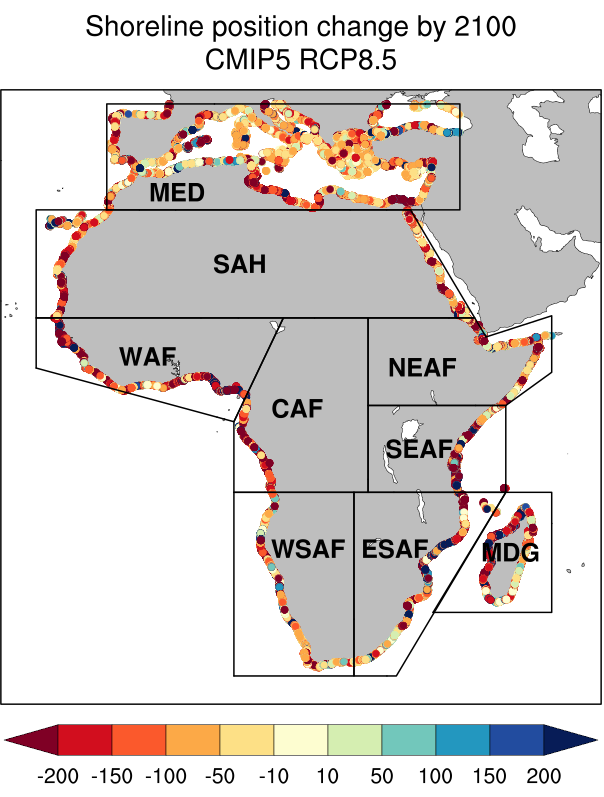

In [2]:
# -- Trim the figure and extract the colorbar
# -----------------------------------------------
from PIL import Image as PILImage
def extract_plot(figure_file,trim_figure) :
    im = PILImage.open(figure_file)
    #box=(left, upper, right, lower).
    im_crop = im.crop((211, 115, 815, 912))
    im_crop.save(trim_figure, quality=95)

scenario='RCP85'
horizon='2100'
outfilename = 'Coastal_Recession_'+str(horizon)+'_'+scenario

# -- color bar file
variable = 'CoastalRecession'
trim_figure = '/home/jservon/Chapter12_IPCC/figs/Figure_12.5/panel_b_AFRICA_'+variable+'_map_'+scenario+'_'+horizon+'.png'
# -- Extract the colorbar
extract_plot(outfilename+'.png',trim_figure)
Image(trim_figure)